# AnomalyDetection_7_MovingAverage_Refinement_2

**Updates from previous notebook:** 
- this notebook will refine the moving_avg() class
   

## Libraries and Configuration

In [1]:
""" Libraries """

#file / system libraries 
import os
import datetime as dt

# mathematical 

from numpy.fft import ifft
from numpy.fft import fft
import numpy as np

# data exploration

import pandas as pd

# data visualization

import matplotlib.pyplot as plt

""" Configuration """

# pandas 

pd.set_option('display.max_columns', None)

## Data

In [2]:
base = '/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/{}'
names = ['rohan','ignacio']
end_labels = ['_filtered.csv']
dfs = []

for index,name in enumerate(names):
    dfs.append(pd.read_csv(base.format(names[index]+end_labels[0]),index_col = 0))

In [3]:
dfs[0] = dfs[0].sort_values(by="date")
print(dfs[0].head())
dfs[0].tail()


                      date  accX  accY  accZ   gyrX   gyrY   gyrZ  files  \
24048  2020-09-09 16:27:07  0.08  0.01  0.11 -13.49   5.99 -21.58      4   
24049  2020-09-09 16:27:08  0.05 -0.03 -0.12  22.86  23.19  -1.88      4   
24050  2020-09-09 16:27:09  0.00 -0.01  0.00   4.29  -5.49   7.91      4   
24051  2020-09-09 16:27:09 -0.03  0.06 -0.14 -16.51  -0.30  -1.01      4   
24052  2020-09-09 16:27:10 -0.01  0.00  0.01   2.25 -21.86  11.49      4   

       accTotal   gyrTotal  
24048  0.136382  26.144915  
24049  0.133417  32.617328  
24050  0.010000  10.540982  
24051  0.155242  16.543585  
24052  0.014142  24.798028  


,date,accX,accY,accZ,gyrX,gyrY,gyrZ,files,accTotal,gyrTotal
7958,2020-09-15 03:05:24,0.03,0.12,0.04,67.21,16.81,35.61,1,0.130000,77.896292
7959,2020-09-15 03:05:25,0.07,0.21,0.14,105.74,43.41,46.95,1,0.261916,123.570539
7960,2020-09-15 03:05:26,0.07,0.21,0.14,27.43,26.10,14.13,1,0.261916,40.413758
7962,2020-09-15 03:05:27,0.01,0.02,0.00,3.29,1.90,1.36,1,0.022361,4.035307
7961,2020-09-15 03:05:27,0.07,0.09,0.05,27.43,26.10,14.13,1,0.124499,40.413758


In [4]:
dfs[1].head()

,date,accX,accY,accZ,gyrX,gyrY,gyrZ,files,accTotal,gyrTotal
0,2020-09-13 17:09:25,0.02,0.12,0.03,1.47,3.32,2.22,1,0.125300,4.255784
1,2020-09-13 17:09:26,0.02,0.12,0.03,1.47,3.32,2.22,1,0.125300,4.255784
2,2020-09-13 17:09:27,0.01,0.01,0.00,7.43,6.82,10.10,1,0.014142,14.273307
12,2020-09-13 17:09:34,0.01,0.01,0.00,6.64,7.07,12.45,1,0.014142,15.782173
13,2020-09-13 17:09:34,0.01,0.01,0.00,4.12,3.61,5.81,1,0.014142,7.985149


In [75]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt


class moving_avg:

    """
    a class used to store a moving average values, parameters and methods
    
    Dependencies:
    -------------
    import datetime as dt
    import numpy as np
    import matplotlib.pyplot as plt
    

    Attributes:
    -----------
    
    data ( class var ): [*[*float]]
        stores all the datapoints for each window
        
    time_frame_start ( class var ): [datetime]
        the start of the moving average window
    
    time_stamps ( class var ): [*[*datetime]]
        stores the timestamps for each data point within it's window
        
    averages ( class var ): [*float]
        stores the values of the moving average for each window    
        
    time_frame ( optional - 5 ): int
        the length of the moving window in units of hours
        
    weight ( optional - (0.0, 0.75) ): (float, float)
        weight to apply to numbers greater than the specified quartile
    
        
    Methods:
    --------
    __init__( self, time_frame = 5, weight = (0.0, 0.75)):
    initialises class based on inputs; converts 'time_frame' to seconds

    
    average( self ):
        calculates the averages for each moving window
        
    plot( self, figsize = (16,8), labels = ('gyrTotal', ' accTotal') ): 
        plots the averages against the start time of the moving moving
        
    create_times ( self ):
        creates a list of the correct plotting index (i.e. real continuous time) with data gaps
    """
    data = [[]]
    time_frame_start = []
    time_stamps = [[]]
    all_data = [[]]
    averages = []


    # note there is a danger in using class variables because they 'save' every instantiations values!
    # note, your reshapes will need to change so that they can adapt for more than 2D data!!!
    def __init__( self, time_frame = 5, weight = (0.0, 0.75)):
        self.time_frame = time_frame*3600
        self.weight = weight

    def plot( self, figsize = (16,8), labels = ('gyrTotal', ' accTotal'), plot_original = False ):
        
        # plot original tells it to plot the original as well!
        self.create_moving_data()
        
        
        averages = np.asarray(self.averages).reshape((-2,2))
        fig = plt.figure(figsize = figsize)
        # need create times here
        real_time = self.create_times(self.time_frame_start)
        all_data = np.asarray(self.all_data).reshape((-2,2))


        for i in range(averages.shape[1]): # this defines the columns
            for row in range(2):
                
                fig.add_subplot(2,averages.shape[1],averages.shape[1]*row+i+1)

                    
                if row%2 == 0:
                    if plot_original == True:
                        plt.plot([j for j in range(len(self.time_stamps[-1]))],all_data[:,i],'.')
                        
                    plt.plot([j for j in range(averages[:,i].shape[0])],averages[:,i],'.')
                    plt.xlabel('discontinuous time, $\hat{t}$, in seconds')


                else:
                    if plot_original == True:
                        real_time_all = self.create_times(self.time_stamps[-1])
                        plt.plot(real_time_all,all_data[:,i],'.')

                        
                    plt.plot(real_time,averages[:,i],'.', markersize = 2)
                    plt.xlabel('continuous time, ${t}$, in seconds')                



                plt.ylabel('average {} in a {} hour window'.format(labels[i],int(self.time_frame/3600)))
                # need to add xticks
                

                


        plt.show()
        
    def create_times ( self, time_array ):
        real_time = [0]
        for time in time_array[1:]:
            real_time.append((time - time_array[0]).total_seconds())
        return real_time
            
        
    def average( self ):   
        for window in self.data:
            window = np.asarray(window).reshape(-2,2)
            self.averages.append([
                window[:,index].mean() for index in range(window.shape[1])
            ])
            
        if (len(self.averages) > 1):
            if (self.averages[-1][0] < self.averages[-2][0]):
                print('risk')
                
    def recent_average( self ):
        
        window = np.asarray(self.data[-1]).reshape(-2,2)
        self.averages.append([
            window[:,index].mean() for index in range(window.shape[1])
        ])
        
    def create_moving_data ( self ):


        if len(self.time_frame_start) == 1:
            self.recent_average()


        counter = 0
        for i,time in enumerate(self.time_stamps[-1]):
            if time not in self.time_frame_start:
                counter += 1
                self.data.append(
                    [[0,0] for j in self.data[-1][:counter]] + self.data[-1][counter:]
                )
                self.time_frame_start.append(time)
                self.recent_average()
        


        #self.time_frame_start.append(self.time_stamps[-1][-1])
        
class average(moving_avg):
    """
    
    Dependencies:
    -------------
    moving_avg (class)
    
    Attributes:
    -----------
    
    datapoint: [*float]
        datapoint to be considered for averaging, length --> degrees of freedom
    
    time: str
        time data point is recorded in the format 'YYYY-mm-dd HH:MM:SS'
        
    Methods:
    --------
    
    __init__(self, datapoint, time):
        initilises class; converts time to datetime; stores new datapoint and time;
        if new time exceeds average window, creates new storage location
        
    """



    
    def __init__(self,datapoint,time):
        
        super().__init__()
        self.datapoint = datapoint
        self.time_stamps[-1].append(dt.datetime.strptime(time,'%Y-%m-%d %H:%M:%S'))
        self.all_data[-1].append(datapoint)
        
        
        if not self.time_frame_start:
            self.time_frame_start.append(self.time_stamps[-1][-1])
            
            
        if (self.time_stamps[-1][-1] - self.time_frame_start[-1]).total_seconds() < self.time_frame:
            pass
        else:

            self.create_moving_data()
            
            self.data.append([])
            
        self.store_new_datapoint()
            
            

    def store_new_datapoint( self ):
        self.data[-1].append([
            point for point in self.datapoint
        ]) # should account for the 'weights' that you've specified here, might require moving the average method
    

        

# what the class is still missing is the 'decision making process', so if an average is lower than 

# need to convert the function that creates new poperties after a 5 hour gap has exceeded so that it can be called
# either in the beginning or in the end! (Also need to create an offset plotting feature as an option !)

## On read data

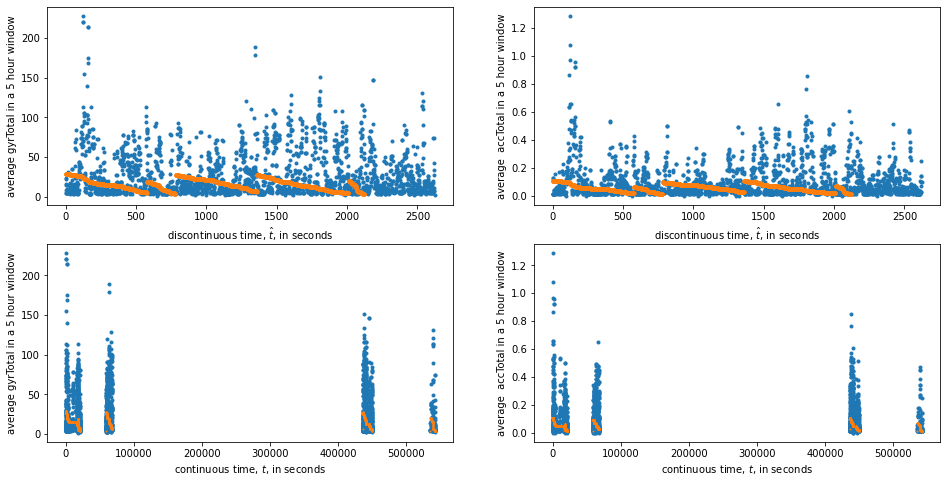

In [76]:
m_avg_instance = moving_avg()
for item in dfs[1][['gyrTotal','accTotal','date']].values.tolist():
    avg_instance = average(item[0:2],item[2])

    
#m_avg_instance.average()
m_avg_instance.plot(plot_original=True)


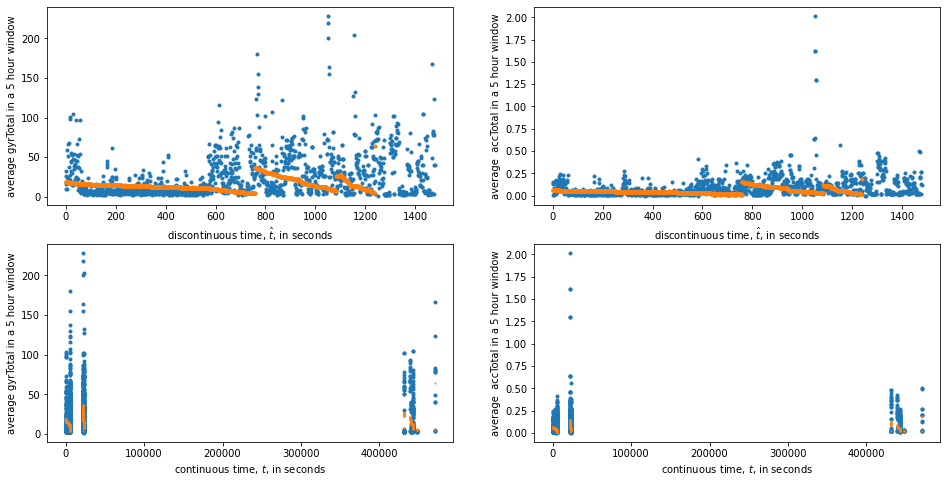

In [70]:
m_avg_instance = moving_avg()
for item in dfs[0][['gyrTotal','accTotal','date']].values.tolist():
    avg_instance = average(item[0:2],item[2])
m_avg_instance.average()
m_avg_instance.plot(plot_original=True)

In [ ]:
newinstance = moving_avg()
for item in dfs[1][['gyrTotal','accTotal','date']].values.tolist():
    avg_instance = average(item[0:2],item[2])

newinstance.average()

plt.plot(dfs[1].index,dfs[1][['gyrTotal','accTotal','date']].values[:,1],'.')

plt.plot([i for i in range(len(newinstance.averages))],np.asarray(newinstance.averages).reshape(-2,2)[:,1])

# Conclusion

The average class works, at least in determining the correct average.

There are some changes you need to make in terms of the actual class though, these are summarised below:
1. Currently, you cannot choose to plot the average, with the data points, or average on it's own
    - UPDATE (25.09.2020): there is now an option allowing you to do so
2. Currently, the average is calculated at the end, as opposed to at every stage (this was done to save memory, but when the model is deployed, you will need to calculate it every time)
3. You need to think about where everything will be stored, and how this will work in conjunction with Rohan's API (best wait for him to come back from holiday before starting this)
4. You need to account for the weightage when calculating the averages
5. You need to add meaningful xticks, in terms of date and time
6. You need to add functionality to be able to determine when there is a 'break' in the sequence (i.e. much lower values?)
7. You need to fix the way your class handles stuff in memory: it currently saves the values from previous instantiations as well